<a href="https://colab.research.google.com/github/MochNad/Pembelajaran-Mesin/blob/main/OCR_to_Bard_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **🍑 Instalasi Tesseract OCR dan Pustaka Python**

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract opencv-python google-generativeai googletrans==4.0.0-rc1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


> # **🍑 Impor Modul dan Pustaka Python**

In [2]:
import io
import os
import time
import shutil
from base64 import b64decode
from IPython.display import display, Image as IPImage, Javascript
from google.colab import drive, files
from google.colab.output import eval_js
from googletrans import Translator
import cv2
import google.generativeai as palm
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from pytesseract import Output, pytesseract

> # **🍑 Menentukan Jalur Folder dan Jalur API**

In [3]:
drive.mount('/content/drive')

path_folder = '/content/drive/MyDrive/PCVK/assets/OCR Bard/'
path_api = path_folder  + 'api_key.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> # **🍑 Mengunggah dan Menyimpan Berkas**

In [4]:
uploaded_files = files.upload()

uploaded_filename = list(uploaded_files.keys())[0]

save_path = os.path.join(path_folder, 'question.jpg')
shutil.move(uploaded_filename, save_path)

Saving image-tesseract-3.png to image-tesseract-3.png


'/content/drive/MyDrive/PCVK/assets/OCR Bard/question.jpg'

> # **🍑 Mengambil dan Menyimpan Foto dari Kamera**

<IPython.core.display.Javascript object>

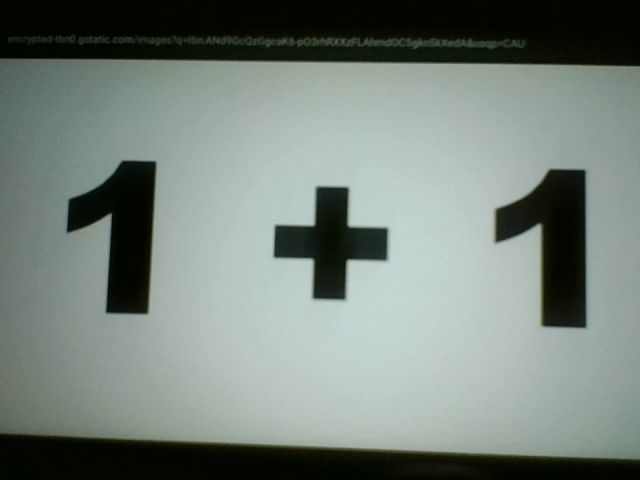

In [5]:
def take_photo(filename='question.jpg', quality=0.8, save_directory='images'):
    save_path = os.path.join(save_directory, filename)

    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');

            const video = document.createElement('video');
            video.style.display = 'block';

            const capture = document.createElement('button');
            capture.textContent = 'Capture';

            div.appendChild(video);
            div.appendChild(capture);

            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({ 'video': true });

            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getVideoTracks()[0].stop();
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    os.makedirs(save_directory, exist_ok=True)

    with open(save_path, 'wb') as f:
        f.write(binary)

    return save_path

image_path = take_photo(filename='question.jpg', save_directory=path_folder)

from IPython.display import Image
Image(filename=image_path)

> # **🍑 Mendeteksi dan Menampilkan Karakter pada Gambar**

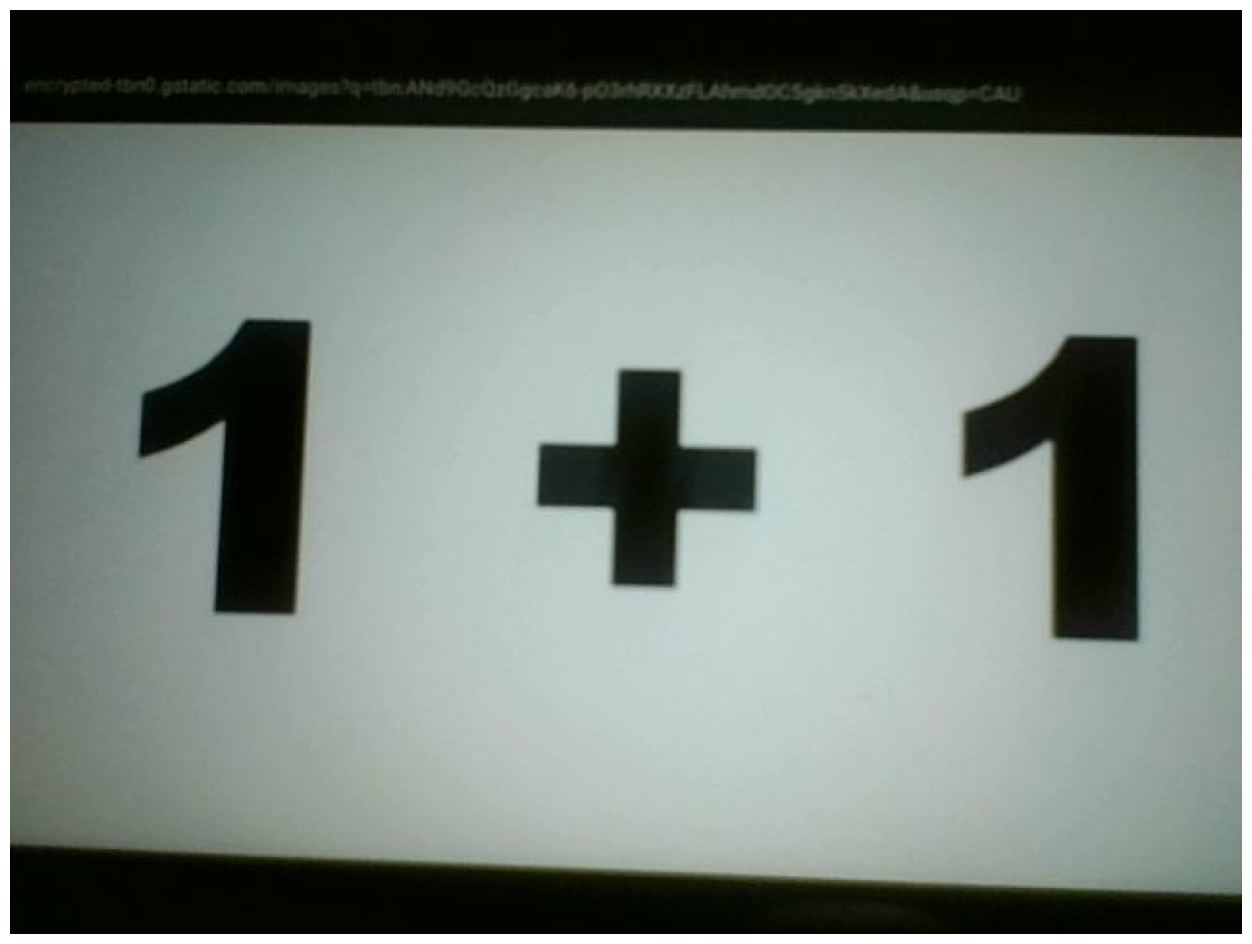

In [6]:
image = cv2.imread(path_folder + 'question.jpg')

h, w, c = image.shape

boxes = pytesseract.image_to_boxes(image)

for b in boxes.splitlines():
    b = b.split(' ')
    karakter_image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 1)

b, g, r = cv2.split(karakter_image)
karakter_img = cv2.merge([r, g, b])

plt.figure(figsize=(16, 12))
plt.imshow(karakter_img)
plt.axis('off')
plt.show()

> # **🍑 Mendeteksi dan Menampilkan Kata pada Gambar**

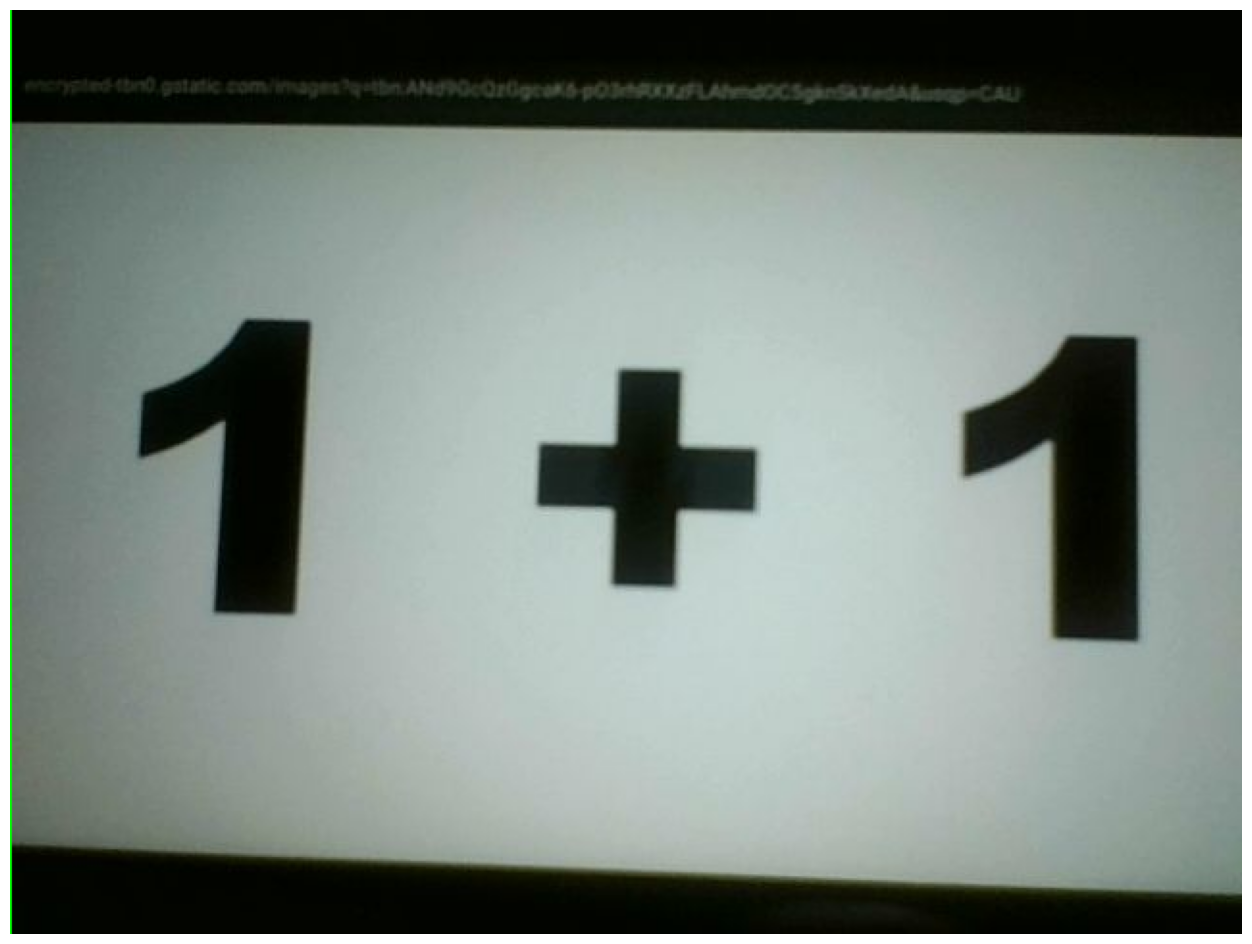

In [7]:
image = cv2.imread(path_folder + 'question.jpg')

d = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        kata_image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

b, g, r = cv2.split(kata_image)
kata_img = cv2.merge([r, g, b])

plt.figure(figsize=(16, 12))
plt.imshow(kata_img)
plt.axis('off')
plt.show()

> # **🍑 Menggunakan Tesseract untuk OCR pada Gambar**

In [8]:
image = cv2.imread(path_folder + 'question.jpg')

custom_config = r'-l eng --oem 3 --psm 6'

prompt = pytesseract.image_to_string(image, config=custom_config)

print("Hasil OCR\t:")
print(prompt)

Hasil OCR	:
1+ 1



> # **🍑 Menggunakan Palm untuk Generate Text Berdasarkan Hasil OCR**

In [9]:
with open(path_api, 'r') as file:
    api_key = file.read().strip()

palm.configure(api_key=api_key)

models = [m for m in palm.list_models() if 'generateText' in m.supported_generation_methods]
model = models[0].name

translator = Translator()
translated_text = translator.translate(prompt, src='id', dest='en').text

completion = palm.generate_text(
    model=model,
    prompt=translated_text,
    temperature=0,
    max_output_tokens=None,
)

translated_result = translator.translate(completion.result, src='en', dest='id').text

print("Soal\t:")
print(prompt)
print("\nJawab\t:")
print(translated_result)

Soal	:
1+ 1


Jawab	:
2
